In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("trip_count_sql").getOrCreate()

In [2]:
# 데이터 디렉토리, 파일 이름 설정
directory = "/home/lab26/SparkCourse/data"
trip_files="/trips/*" # trips 폴더에 들어있는 모든 파일
zone_file= "taxi+_zone_lookup.csv"

In [3]:
trips_df = spark.read.csv(f"file:///{directory}/{trip_files}", inferSchema=True, header=True)
zone_df = spark.read.csv(f"file:///{directory}/{zone_file}", inferSchema=True, header=True)

In [4]:
trips_df.printSchema()
zone_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [5]:
trips_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zone")

`DataLake` -> `Data Warehouse`

In [6]:
# trips_df와 zone_df를 합친 새로운 DataFrame 만들어주기 (Warehouse)

query = """
select
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,
    
    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,
    
    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone

from trips t
left join
    zone pz
on t.PULocationID = pz.LocationID
left join
    zone dz
on t.DOLocationID = dz.LocationID
"""

comb_df = spark.sql(query)
comb_df.createOrReplaceTempView("comb")

In [7]:
query = """
select pickup_date, pickup_time
from comb
where pickup_time > 0
"""

spark.sql(query).show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-03-01|         22|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
+-----------+-----------+
only showing top 20 rows



In [8]:
query = """
select pickup_date, pickup_time
from comb
where pickup_date < '2020-12-31' 
"""

spark.sql(query).show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          1|
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|         16|
| 2009-01-01|         16|
| 2009-01-01|          0|
| 2009-01-01|          0|
+-----------+-----------+
only showing top 20 rows



**정제 작업**

### 요금 (`total_amount`) 확인

In [9]:
# 요금 확인
comb_df.select("total_amount").describe().show()

+-------+-----------------+
|summary|     total_amount|
+-------+-----------------+
|  count|         15000700|
|   mean|18.75545205708744|
| stddev|145.7442452805979|
|    min|           -647.8|
|    max|         398469.2|
+-------+-----------------+



음수값 존재.. 택시비가 음수?

In [10]:
# 운행 거리 확인
comb_df.select("trip_distance").describe().show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         15000700|
|   mean|6.628629402627818|
| stddev|671.7293482115828|
|    min|              0.0|
|    max|        332541.19|
+-------+-----------------+



min 이 0.0인 데이터가 있음

In [11]:
# 승객수 확인
comb_df.select("passenger_count").describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          14166672|
|   mean|1.4253783104458126|
| stddev|  1.04432704905968|
|    min|                 0|
|    max|                 9|
+-------+------------------+



count 가 줄어들었다

In [12]:
# 월별 운행수 확인
query = """
select
    DATE_TRUNC('MM',c.pickup_date) as month,
    count(*) as trips
from 
    comb c
group by month
order by month desc
"""

spark.sql(query).show()

+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2029-05-01 00:00:00|      1|
|2021-12-01 00:00:00|      5|
|2021-11-01 00:00:00|      5|
|2021-10-01 00:00:00|      3|
|2021-09-01 00:00:00|      3|
|2021-08-01 00:00:00|     36|
|2021-07-01 00:00:00|2821430|
|2021-06-01 00:00:00|2834204|
|2021-05-01 00:00:00|2507075|
|2021-04-01 00:00:00|2171215|
|2021-03-01 00:00:00|1925130|
|2021-02-01 00:00:00|1371688|
|2021-01-01 00:00:00|1369749|
|2020-12-01 00:00:00|     16|
|2009-01-01 00:00:00|    111|
|2008-12-01 00:00:00|     26|
|2004-04-01 00:00:00|      1|
|2003-01-01 00:00:00|      1|
|2002-12-01 00:00:00|      1|
+-------------------+-------+



올바른 데이터만 사용하기 위해서 데이터를 정제.`Data Warehouse -> Data Mart`

In [13]:
# Data Cleaning
query = """
SELECT *
FROM comb c
WHERE c.total_amount < 5000
  AND c.total_amount > 0
  AND c.passenger_count < 4
  AND c.pickup_date >= '2021-01-01'
  AND c.pickup_date < '2021-08-01'
"""

cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView("cleaned")

In [14]:
cleaned_df.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+--------------------+
|summary|         vendor_id|       pickup_time|      dropoff_time|   passenger_count|    trip_distance|       fare_amount|        tip_amount|       tolls_amount|      total_amount|       payment_type|         pickup_zone|        dropoff_zone|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+--------------------+
|  count|          13297707|          13297707|          13297707|          13297707|         13297707|          13297707|          13297707|           13297707|          13297707|           13297707|            13297707|            13297707|
|   mean|1.6708664132846363|

# 시각화

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [16]:
query = """
SELECT c.pickup_date,
       COUNT(*) as trips
FROM cleaned c
GROUP BY c.pickup_date
"""

pd_df = spark.sql(query).toPandas()
pd_df

,pickup_date,trips
0,2021-06-22,89161
1,2021-01-27,46044
2,2021-05-12,77679
3,2021-07-20,82829
4,2021-07-30,88229
...,...,...
207,2021-02-04,51088
208,2021-06-15,88271
209,2021-04-10,61471
210,2021-04-12,61791


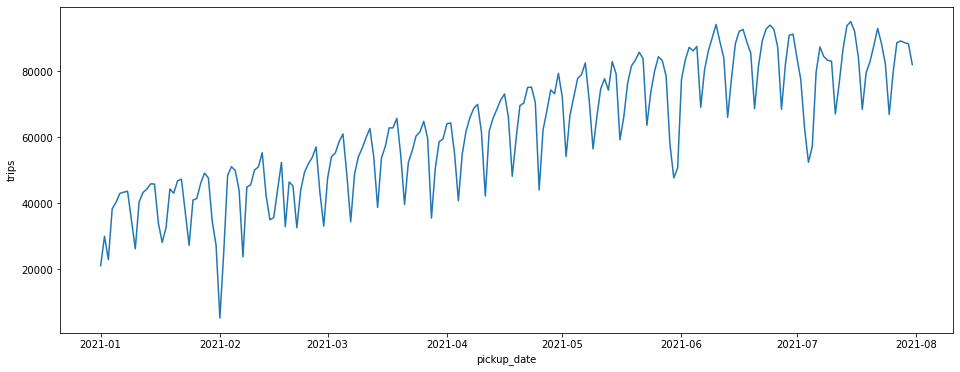

In [17]:
plt.subplots(figsize = (16,6))
sns.lineplot(x='pickup_date', y='trips', data = pd_df)
plt.show()

### 요일별 trips 의 중간값 확인

In [18]:
# DATE_FORMAT(c.pickup_date, 'EEEE') -> pickup_date의 요일 알아내기
query = """
SELECT c.pickup_date,
       DATE_FORMAT(c.pickup_date, 'EEEE') as day_of_week,
       COUNT(*) AS trips
FROM cleaned c
GROUP BY c.pickup_date, day_of_week
"""

pd_df2 = spark.sql(query).toPandas()
pd_df2

,pickup_date,day_of_week,trips
0,2021-04-23,Friday,75142
1,2021-05-26,Wednesday,84364
2,2021-03-24,Wednesday,60382
3,2021-02-15,Monday,35671
4,2021-07-30,Friday,88229
...,...,...,...
207,2021-01-16,Saturday,34037
208,2021-06-04,Friday,86134
209,2021-05-08,Saturday,71310
210,2021-01-03,Sunday,22942


In [19]:
data = pd_df2.groupby("day_of_week")["trips"].median().to_frame()
data = data.reset_index()
data

,day_of_week,trips
0,Friday,73094.0
1,Monday,56066.5
2,Saturday,61471.0
3,Sunday,43131.5
4,Thursday,72194.5
5,Tuesday,66822.0
6,Wednesday,69399.0


In [20]:
# 요일 정렬(일월화수목금토)
data["sort_dow"] = data["day_of_week"].replace({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
})
data

,day_of_week,trips,sort_dow
0,Friday,73094.0,5
1,Monday,56066.5,1
2,Saturday,61471.0,6
3,Sunday,43131.5,0
4,Thursday,72194.5,4
5,Tuesday,66822.0,2
6,Wednesday,69399.0,3


In [21]:
data = data.sort_values(by='sort_dow')
data

,day_of_week,trips,sort_dow
3,Sunday,43131.5,0
1,Monday,56066.5,1
5,Tuesday,66822.0,2
6,Wednesday,69399.0,3
4,Thursday,72194.5,4
0,Friday,73094.0,5
2,Saturday,61471.0,6


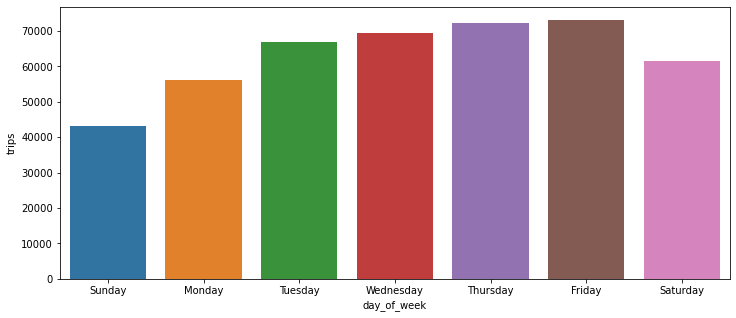

In [22]:
plt.figure(figsize=(12, 5))
sns.barplot(
    x='day_of_week',
    y='trips',
    data=data
)
plt.show()

UDF 활용해보기

In [23]:
def get_weekday(date):
    import calendar
    return calendar.day_name[date.weekday()]

spark.udf.register("get_weekday", get_weekday)

<function __main__.get_weekday(date)>

In [24]:
query = """
SELECT c.pickup_date,
       get_weekday(c.pickup_date) as day_of_week,
       COUNT(*) AS trips
FROM cleaned c
GROUP BY c.pickup_date, day_of_week
"""

pd_df3 = spark.sql(query).toPandas()
pd_df3

,pickup_date,day_of_week,trips
0,2021-04-23,Friday,75142
1,2021-05-26,Wednesday,84364
2,2021-03-24,Wednesday,60382
3,2021-02-15,Monday,35671
4,2021-07-30,Friday,88229
...,...,...,...
207,2021-01-16,Saturday,34037
208,2021-06-04,Friday,86134
209,2021-05-08,Saturday,71310
210,2021-01-03,Sunday,22942


## 결제 유형 별 분석하기

In [25]:
payment_type_to_string = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip",
}

def parse_payment_type(payment_type):
    return payment_type_to_string[payment_type]

In [26]:
spark.udf.register("parse_payment_type", parse_payment_type)

<function __main__.parse_payment_type(payment_type)>

In [27]:
query = """
select parse_payment_type(c.payment_type),
       count(*) as trips,
       mean(c.fare_amount) as mean_fare_amount,
       std(c.fare_amount) as std_fare_amount
from cleaned c

group by c.payment_type
"""

spark.sql(query).show()

+--------------------------------+--------+------------------+------------------+
|parse_payment_type(payment_type)|   trips|  mean_fare_amount|   std_fare_amount|
+--------------------------------+--------+------------------+------------------+
|                     Credit Card|10118303|12.218953262221572|10.838864815920585|
|                       No Charge|   58553|11.930844534011921|15.037771181522627|
|                         Unknown|       1|              17.8|              null|
|                         Dispute|   23537|12.682116667374768|14.832463920441812|
|                            Cash| 3097313|11.987148124842387|11.698050602195234|
+--------------------------------+--------+------------------+------------------+



In [28]:
spark.stop()